# Check Duplicates, Loops and Dead Ends
After balancing the models in 02_balancing_metabolic_models the models went into Frowins Macaw Scripts, i.e. doing macaw run (everything but dilution test because of runtime) in MACAW_Phase_1_tests and then using the results to fix exact and directionality duplicates. Now we can try to further use the macaw (and also memote) results to curate the models. Firstly, we continue we duplicates (reaction duplicates and then check metabolites because maybe deleting some reactions can already help if we can also delete metabolites). Dead-Ends and Loops (and maybe in this context also energy generating cycles) need to be examined afterwards.

# Imports

In [1]:
from cobra.io import read_sbml_model, write_sbml_model, save_json_model
import os
import pandas as pd
from collections import Counter
import random
import matplotlib.pyplot as plt
from cobra.manipulation.validate import check_mass_balance
from itertools import cycle
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import re
import ast

from requests.sessions import merge_hooks

In [76]:
# Load SBML Models
models_path = "../Models/04_after_macaw_fixes/"
models_curation = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_curate")
    models_curation[name] = model

models_curation = {key: models_curation[key] for key in sorted(models_curation.keys())}  # sorts the dictionary alphabetically
AA1_curate, AA2_curate, AA3_curate, AA4_curate, AA5_curate, AA6_curate, AA7_curate = [models_curation[f"AA{i}_curate"] for i in range(1, 8)]

In [3]:
# Load macaw Results
report_path = "../Reports/B_Macaw_after_Duplicate_removing/"
macaw = {}

for file in os.listdir(report_path):
    if file.endswith('.csv'):
        file_path = os.path.join(report_path, file)
        df_name = file.replace('.csv', '')
        macaw[df_name] = pd.read_csv(file_path)

macaw = {key: macaw[key] for key in sorted(macaw.keys())}
AA1_macaw, AA2_macaw, AA3_macaw, AA4_macaw, AA5_macaw, AA6_macaw, AA7_macaw = [macaw[f"AA{i}_curated_afterphase_1"] for i in range(1, 8)]

# Functions

In [3]:
def get_rxn(model, rxn_id, print_mass = False, print_GPR=False):
    rxn = model.reactions.get_by_id(rxn_id)
    charges = {met.id: met.charge for met in rxn.metabolites}
    masses = {met.id: met.formula for met in rxn.metabolites}
    gpr = rxn.gene_reaction_rule
    if print_mass and print_GPR:
        print(rxn, charges, masses, gpr)
    elif print_mass:
        print(rxn, charges, masses)
    elif print_GPR:
        print(rxn, charges)
        print(gpr)
    else:
        print(rxn, charges)

In [4]:
def get_rxn_unknown(rxn_id, print_mass = False, print_GPR=False):
    model_list = []
    gpr_list= []
    for model in models_curation.values():
        if rxn_id in model.reactions:
            model_list.append(model)
            gpr_list.append(model.reactions.get_by_id(rxn_id).gene_reaction_rule)

    print(f"{rxn_id} is found in: {[model.id for model in model_list]}")

    if model_list:
        get_rxn(model_list[0], rxn_id, print_mass)

    if print_GPR:
        print(f"all GPRs: {set(gpr_list)}")

In [5]:
def get_met(model, met_id, print_rxn = True):
    met = model.metabolites.get_by_id(met_id)
    rxns_id = [rxn.id for rxn in met.reactions]
    rxns = {rxn.id:model.reactions.get_by_id(rxn.id).reaction for rxn in met.reactions}
    print(f"{met.name} ({met.formula}, {met.charge})")
    if print_rxn:
        print(rxns)
    else:
        print(rxns_id)

In [6]:
def get_met_unknown(met_id):
    model_list = []
    rxn_list = []
    for model in models_curation.values():
        if met_id in model.metabolites:
            model_list.append(model)
            rxns = model.metabolites.get_by_id(met_id).reactions
            for rxn in rxns:
                rxn_list.append(rxn.id)

    met_name, met_formula, met_charge = ["" for _ in range(3)]
    if model_list:
        met_name = model_list[0].metabolites.get_by_id(met_id).name
        met_formula = model_list[0].metabolites.get_by_id(met_id).formula
        met_charge = model_list[0].metabolites.get_by_id(met_id).charge
    print(f"{met_id} ({met_name} ({met_formula}, {met_charge})) is found  models: {[model.id for model in model_list]} and in reactions: {set(rxn_list)}")

In [7]:
def check_delete(model, compare_list):
    if len(compare_list) != 2:
        print("Please provide exactly two reactions to compare")
        return

    if compare_list[0] in model.reactions and compare_list[1] in model.reactions:
        rxn1 = model.reactions.get_by_id(compare_list[0])
        rxn2 = model.reactions.get_by_id(compare_list[1])

        if rxn1.gene_reaction_rule == rxn2.gene_reaction_rule:
            print(f"Same GPR for both reactions: {rxn1.gene_reaction_rule}")
        else:
            print(f"different GPR for both reactions: {rxn1.gene_reaction_rule} for {compare_list[0]} vs. {rxn2.gene_reaction_rule} for {compare_list[1]}")
    else:
        print("Not all reactions are in the model")

In [8]:
def overwrite_charge(model, rxn_id, new_charge):
    if rxn_id in model.metabolites:
        model.metabolites.get_by_id(rxn_id).charge = new_charge

def overwrite_formula(model, rxn_id, new_formula):
    if rxn_id in model.metabolites:
        model.metabolites.get_by_id(rxn_id).formula = new_formula

def overwrite_reaction(model, rxn_id, new_rxn_dict):
    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        rxn.subtract_metabolites(rxn.metabolites)
        rxn.add_metabolites(new_rxn_dict)

In [9]:
def extract_met_info_model(model):
    met_infos = []

    for met in model.metabolites:
        met_infos.append({
            "bigg_id": met.id.rsplit("_", 1)[0],  # strip compartment so that it matches the actual BIGG ID that also doesn't have compartments (e.g., glc__D_c to glc__D)
            "model_id": met.id,
            "model_formula": met.formula,
            "model_charge": met.charge
        })

    met_infos = pd.DataFrame(met_infos)
    return met_infos

# Check Metabolite Duplicates
Based on the Memote reports that were done after the first mass balancing of the models (i.e. after using Frowins Scripts), we need to check the identified duplicate metabolites. Are these real duplicated metabolites?

### Memote Duplicates by Frowin
Frowin has 31 metabolite duplicates in all his models and I have 25 of them.

In [9]:
memote_metabolites_frowin = [('3hbcoa_c', '3hbycoa_c'),
 ('isetac_e', 'istnt_e'),
 ('metox_e', 'metsox_S__L_e'),
 ('eths_c', 'ethso3_c'),
 ('eths_e', 'ethso3_e'),
 ('nh3_c', 'nh4_c'), # this is not a duplicate
 ('glcn__D_e', 'glcn_e'),
 ('galct__D_c', 'galctr__D_c'),
 ('34dhpacet_c', '34dhpha_c'),
 ('stcoa_c', 'strcoa_c'),
 ('aacald_c', 'amacald_c'),
 ('acamoxm_c', 'nal2a6o_c'),
 ('1btol_c', 'btoh_c'),
 ('orn__L_e', 'orn_e'),
 ('abt__L_c', 'abt_c'),
 ('2hxmp_c', '2hymeph_c'),
 ('dd2coa_c', 'trans_dd2coa_c'),
 ('abt__L_e', 'abt_e'),
 ('2kmb_c', '4met2obut_c'),
 ('2h3opp_c', '2h3oppan_c'),
 ('glcn__D_c', 'glcn_c'),
 ('sula_e', 'sulfac_e'),
 ('sula_c', 'sulfac_c'),
 ('isetac_c', 'istnt_c'),
 ('metox_c', 'metsox_S__L_c'),
 ('5d4dglcr_c', '5dh4dglc_c'),
 ('orn__L_c', 'orn_c'),
 ('galct__D_e', 'galctr__D_e'),
 ('3hibutcoa_c', 'hibcoa_c'),
 ('dscl_c', 'shcl_c'),
 ('scl_c', 'srch_c')]

memote_metabolites_frowin = sorted(set(tuple(sorted(t)) for t in memote_metabolites_frowin))

In [12]:
# duplicate metabolites (are also in the list above) but that are not in reactions that have a duplicate
dups_without_dups_rxns = ["eths_c", "ethso3_c",
# "nh3_c","nh4_c",
"stcoa_c","strcoa_c",
"aacald_c","amacald_c",
"1btol_c","btoh_c",
"2hxmp_c","2hymeph_c",
"2kmb_c","4met2obut_c",
"sula_c","sulfac_c",
"isetac_c","istnt_c",
"3hibutcoa_c", "hibcoa_c"]

In [10]:
# Lisas Metabolite Duplicates according to Memote for all models (i copy and pasted them just from memote so in that list below there are still duplicates that get filter out later on)
memote_metabolites_lisa = [["3hbcoa_c", "3hbycoa_c"], ["aacald_c", "amacald_c"], ["dd2coa_c", "trans_dd2coa_c"],
                           ["nh3_c", "nh4_c"], ["orn__L_c", "orn_c"], ["orn__L_e", "orn_e"],
                           ["1btol_c", "btoh_c"], ["2h3opp_c", "2h3oppan_c"], ["34dhpacet_c", "34dhpha_c"],
                           ["3hbcoa_c", "3hbycoa_c"], ["aacald_c", "amacald_c"], ["abt__L_c", "abt_c"],
                           ["dd2coa_c", "trans_dd2coa_c"], ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"],
                           ["orn__L_c", "orn_c"],
                           ["3hbcoa_c", "3hbycoa_c"], ["abt__L_c", "abt_c"], ["abt__L_e", "abt_e"],
                           ["dd2coa_c", "trans_dd2coa_c"], ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"],
                           ["orn__L_c", "orn_c"], ["orn__L_e", "orn_e"], ["stcoa_c", "strcoa_c"],
                           ["2kmb_c", "4met2obut_c"], ["34dhpacet_c", "34dhpha_c"], ["metox_c", "metsox_S__L_c"],
                           ["metox_e", "metsox_S__L_e"], ["nh3_c", "nh4_c"],
                           ["1btol_c", "btoh_c"], ["3hbcoa_c", "3hbycoa_c"], ["abt__L_c", "abt_c"],
                           ["dd2coa_c", "trans_dd2coa_c"], ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"],
                           ["orn__L_c", "orn_c"],
                           ["1btol_c", "btoh_c"], ["2h3opp_c", "2h3oppan_c"], ["2kmb_c", "4met2obut_c"],
                           ["34dhpacet_c", "34dhpha_c"], ["3hbcoa_c", "3hbycoa_c"], ["5d4dglcr_c", "5dh4dglc_c"],
                           ["aacald_c", "amacald_c"], ["dd2coa_c", "trans_dd2coa_c"], ["eths_c", "ethso3_c"],
                           ["eths_e", "ethso3_e"], ["galct__D_c", "galctr__D_c"], ["galct__D_e", "galctr__D_e"],
                           ["glcn__D_c", "glcn_c"], ["isetac_c", "istnt_c"], ["isetac_e", "istnt_e"],
                           ["metox_c", "metsox_S__L_c"], ["nh3_c", "nh4_c"], ["orn__L_c", "orn_c"],
                           ["orn__L_e", "orn_e"], ["sula_c", "sulfac_c"], ["sula_e", "sulfac_e"],
                           ["aacald_c", "amacald_c"], ["eths_c", "ethso3_c"], ["eths_e", "ethso3_e"],
                           ["isetac_c", "istnt_c"], ["isetac_e", "istnt_e"], ["nh3_c", "nh4_c"], ["sula_c", "sulfac_c"],
                           ["sula_e", "sulfac_e"]]

In [14]:
# I dont have any unique metabolite duplicates that Frowin does not have
memote_metabolites_lisa = list(set(tuple(x) for x in memote_metabolites_lisa))
memote_metabolites_lisa = sorted(set(tuple(sorted(t)) for t in memote_metabolites_lisa))

# Convert to sets for comparison
set_frowin = set(memote_metabolites_frowin)
set_lisa = set(memote_metabolites_lisa)

set_frowin_diff = set_frowin - set_lisa
set_lisa_diff = set_lisa - set_frowin

print("Only in Frowin:", set_frowin_diff)
print("Only in Lisa:", set_lisa_diff)

Only in Frowin: {('2hxmp_c', '2hymeph_c'), ('dscl_c', 'shcl_c'), ('scl_c', 'srch_c'), ('glcn__D_e', 'glcn_e'), ('acamoxm_c', 'nal2a6o_c'), ('3hibutcoa_c', 'hibcoa_c')}
Only in Lisa: set()


In [15]:
memote_metabolites_lisa

[('1btol_c', 'btoh_c'),
 ('2h3opp_c', '2h3oppan_c'),
 ('2kmb_c', '4met2obut_c'),
 ('34dhpacet_c', '34dhpha_c'),
 ('3hbcoa_c', '3hbycoa_c'),
 ('5d4dglcr_c', '5dh4dglc_c'),
 ('aacald_c', 'amacald_c'),
 ('abt__L_c', 'abt_c'),
 ('abt__L_e', 'abt_e'),
 ('dd2coa_c', 'trans_dd2coa_c'),
 ('eths_c', 'ethso3_c'),
 ('eths_e', 'ethso3_e'),
 ('galct__D_c', 'galctr__D_c'),
 ('galct__D_e', 'galctr__D_e'),
 ('glcn__D_c', 'glcn_c'),
 ('isetac_c', 'istnt_c'),
 ('isetac_e', 'istnt_e'),
 ('metox_c', 'metsox_S__L_c'),
 ('metox_e', 'metsox_S__L_e'),
 ('nh3_c', 'nh4_c'),
 ('orn__L_c', 'orn_c'),
 ('orn__L_e', 'orn_e'),
 ('stcoa_c', 'strcoa_c'),
 ('sula_c', 'sulfac_c'),
 ('sula_e', 'sulfac_e')]

In [11]:
metabolis = [m for met in memote_metabolites_frowin for m in met]  # flatten list

In [18]:
# get BIGG info on metabolites that are duplicate, in this case info about the models they occur in
# there are some BIGG models that we often have trouble with and we want to confirm that
base_url = "http://bigg.ucsd.edu/api/v2/universal/metabolites"
response = requests.get(base_url)

# check if request is going through
if response.status_code != 200:
    raise Exception("Failed to fetch metabolite list")


def fetch_metabolite_details(met):
    bigg_id = met[:-2]
    url = f"{base_url}/{bigg_id}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200:
            data = r.json()  # converts JSON response to a dictionary (data)
            bigg_model = data.get("compartments_in_models", [])

            bigg_model_id = []
            for model in bigg_model:
                bigg_model_id.append(model["model_bigg_id"])

            return {
                "bigg_id": bigg_id,
                "name": met,
                "bigg_models": list(set(bigg_model_id))
            }

    except Exception as e:
        print(f"Error with {bigg_id}: {e}")
    return {
        "bigg_id": bigg_id,
    }


# Use ThreadPoolExecutor to parallelise requests
results = []
with ThreadPoolExecutor(max_workers=1) as executor: # use 1 so order stays the same
    futures = [executor.submit(fetch_metabolite_details, met) for met in metabolis]
    for i, future in enumerate(as_completed(futures)):
        results.append(future.result())

df = pd.DataFrame(results)

In [19]:
aaaaah_counter = 0
big_aaaaah_counter = 0

counter = cycle([0, 1])
pair_counter = 0
pairs = [False, False]

for bigg_id in df["bigg_models"]:
    i = next(counter)

    if bigg_id == ["iYO844"]:
        big_aaaaah_counter += 1
        pairs[i] = True
    elif "iYO844" in bigg_id:
        aaaaah_counter += 1
        pairs[i] = True
    else:
        pairs[i] = False

    if (i + 1) % 2 == 0:
        if pairs == [True, True]:
            print("öhm?")
        #if pairs == [False, False]:
            #print(bigg_id)
        if True in pairs:
            pair_counter += 1
            pairs = [False, False]

print(f"{big_aaaaah_counter} metabolites are ONLY in Model iYO844.")
print(f"{aaaaah_counter} metabolites are in Model iYO844 but also in others.")
print(f"That means {pair_counter} duplicate pairs from {int(len(metabolis) / 2)} have a iYO844 problem.")

17 metabolites are ONLY in Model iYO844.
12 metabolites are in Model iYO844 but also in others.
That means 29 duplicate pairs from 31 have a iYO844 problem.


### Memote Duplicates in-depth inspection

Copy possible duplicated metabolites from the memote reports (after first Frowin/Macaw fixes, see Reports/05 folder)

In [102]:
AA1_met_dup = [["3hbcoa_c","3hbycoa_c"],["aacald_c","amacald_c"],["dd2coa_c","trans_dd2coa_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"]]

In [103]:
AA2_duplicates = [["1btol_c","btoh_c"],["2h3opp_c","2h3oppan_c"],["34dhpacet_c","34dhpha_c"],["3hbcoa_c","3hbycoa_c"],["aacald_c","amacald_c"],["abt__L_c","abt_c"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"]]

In [104]:
AA3_duplicates = [["3hbcoa_c","3hbycoa_c"],["abt__L_c","abt_c"],["abt__L_e","abt_e"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"],["stcoa_c","strcoa_c"]]

In [106]:
AA4_duplicates = [["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["metox_c","metsox_S__L_c"],["metox_e","metsox_S__L_e"],["nh3_c","nh4_c"]]

In [105]:
AA5_duplicates = [["1btol_c","btoh_c"],["3hbcoa_c","3hbycoa_c"],["abt__L_c","abt_c"],["dd2coa_c","trans_dd2coa_c"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"]]

In [107]:
AA6_duplicates = [["1btol_c","btoh_c"],["2h3opp_c","2h3oppan_c"],["2kmb_c","4met2obut_c"],["34dhpacet_c","34dhpha_c"],["3hbcoa_c","3hbycoa_c"],["5d4dglcr_c","5dh4dglc_c"],["aacald_c","amacald_c"],["dd2coa_c","trans_dd2coa_c"],["eths_c","ethso3_c"],["eths_e","ethso3_e"],["galct__D_c","galctr__D_c"],["galct__D_e","galctr__D_e"],["glcn__D_c","glcn_c"],["isetac_c","istnt_c"],["isetac_e","istnt_e"],["metox_c","metsox_S__L_c"],["nh3_c","nh4_c"],["orn__L_c","orn_c"],["orn__L_e","orn_e"],["sula_c","sulfac_c"],["sula_e","sulfac_e"]]

In [108]:
AA7_duplicates = [["aacald_c","amacald_c"],["eths_c","ethso3_c"],["eths_e","ethso3_e"],["isetac_c","istnt_c"],["isetac_e","istnt_e"],["nh3_c","nh4_c"],["sula_c","sulfac_c"],["sula_e","sulfac_e"]]

In [169]:
duplicates = [val for name, val in globals().items() if isinstance(val, list) and name.startswith('AA')]

In [170]:
# get the unique duplicates across all models
unique_duplicates = set()
for outer in duplicates:
    for inner in outer:
        unique_duplicates.add(tuple(inner))

In [171]:
print(f'There are {len(unique_duplicates)} duplicates (tuples) across all models, i.e. in total {len(unique_duplicates)*2} metabolites to check.')

There are 0 duplicates (tuples) across all models, i.e. in total 0 metabolites to check.


In [ ]:
ecoli = read_sbml_model("iML1515.xml")
ecoli.solver = 'cplex'

In [3]:
import cobra
from cobra.io import read_sbml_model, write_sbml_model
# from macaw.main import run_all_tests

ecoli = read_sbml_model('iML1515.xml')

Restricted license - for non-production use only - expires 2026-11-23


## Fix Metabolite Duplicates

In [3]:
def parse_gpr(gpr_str):
    # Split on ' or ' but keep "A and B" as one element
    parts = re.split(r'\s+or\s+', gpr_str)
    # Strip and unify whitespace
    parts = [' '.join(p.strip().split()) for p in parts if p.strip()]
    return set(parts)


def merge_gpr(del_rxn_gpr, keep_rxn_gpr):

    if del_rxn_gpr == "" and keep_rxn_gpr == "":
        return ""

    elif del_rxn_gpr == "":
        return keep_rxn_gpr
    elif keep_rxn_gpr == "":
        return del_rxn_gpr

    else:
        del_rxn_gpr = parse_gpr(del_rxn_gpr)
        keep_rxn_gpr = parse_gpr(keep_rxn_gpr)

        merged_gpr = sorted(del_rxn_gpr.union(keep_rxn_gpr))  # Sort for consistency

        return ' or '.join(merged_gpr)

In [77]:
def fix_metabolite_duplicates(model, met_delete, met_keep, rxn_dup_pairs,):

    # (0) check if met_delete is in current model and rxn_dup_pairs has right format
    if met_delete in model.metabolites and all(len(pair) == 2 for pair in rxn_dup_pairs):

        # (1) delete all rxns from met_delete that are in rxn_dup_pairs if met_delete in model
        rxns_met_delete = [rxn[0] for rxn in rxn_dup_pairs if rxn[0] in model.reactions] # all reactions that we need to delete (if they are in the current model)
        rxns_met_keep = [rxn[1] for rxn in rxn_dup_pairs if rxn[1] in model.reactions]

        for dup_pair in rxn_dup_pairs:
            del_rxn, keep_rxn = dup_pair

            # (1.1) if both rxns of one rxn_dup_pairs in model
            if del_rxn in rxns_met_delete and keep_rxn in rxns_met_keep:
                # (1.1.1) merge gpr onto rxn_keep
                del_rxn_gpr = model.reactions.get_by_id(del_rxn).gene_reaction_rule
                keep_rxn_gpr = model.reactions.get_by_id(keep_rxn).gene_reaction_rule
                model.reactions.get_by_id(keep_rxn).gene_reaction_rule = merge_gpr(del_rxn_gpr, keep_rxn_gpr)

                # (1.1.2) delete del_rxn from model
                model.remove_reactions([model.reactions.get_by_id(del_rxn)])

            # (1.2) if only keep_rxn in model, continue with next rxn
            elif keep_rxn in rxns_met_keep:
                continue

            # (1.3) if only del_rxn in model
            elif del_rxn in rxns_met_delete:
                del_rxn_model = model.reactions.get_by_id(del_rxn)
                met_delete_model = model.metabolites.get_by_id(met_delete)
                if met_delete_model in del_rxn_model.metabolites: # should always be the case
                    # (1.3.1) replace met_delete with met_keep in del_rxn
                    coeff = del_rxn_model.get_coefficient(met_delete) # save stoichiometry/coefficient of met_delete

                    # if met_keep doesnt exist in the model, make copy of met_delete but give it ID of met_keep
                    # i cannot just change the id of met_delete because then (3) doesnt work so universally anymore
                    if met_keep not in model.metabolites:
                        original_met = model.metabolites.get_by_id(met_delete)
                        met_keep_model = original_met.copy()
                        met_keep_model.id = met_keep
                        model.add_metabolites([met_keep_model])

                    del_rxn_model.add_metabolites({met_keep: coeff}) # use that coefficient to add met_keep
                    del_rxn_model.add_metabolites({met_delete: -coeff}) # delete met_delete from reaction

                    # (1.3.2) replace id del_rxn with id keep_rxn
                    del_rxn_model.id = keep_rxn

            else:
                #print(f"Problems regarding the duplicate pair: {dup_pair} in model {model.id}. Check manually.")
                # both reactions are not in model, so we can go to next pair
                continue

        # (2) check if met_delete has rxns left (these are the ones without duplicates that we want to keep)
        left_rxns = [rxn.id for rxn in model.metabolites.get_by_id(met_delete).reactions if rxn.id not in rxns_met_delete]

        # (2.1) change met_delete to met_keep in left_rxns
        for rxn in left_rxns:
            rxn_model = model.reactions.get_by_id(rxn)
            coeff = rxn_model.get_coefficient(met_delete)

            # if met_keep doesnt exist in the model, make copy of met_delete but give it ID of met_keep
            # i cannot just change the id of met_delete because then (3) doesnt work so universally anymore
            if met_keep not in model.metabolites:
                original_met = model.metabolites.get_by_id(met_delete)
                met_keep_model = original_met.copy()
                met_keep_model.id = met_keep
                model.add_metabolites([met_keep_model])

            rxn_model.add_metabolites({met_keep: coeff})
            rxn_model.add_metabolites({met_delete: -coeff})

        # (3) delete met_delete
        if len(model.metabolites.get_by_id(met_delete).reactions) == 0:
            met = model.metabolites.get_by_id(met_delete)
            model.metabolites.remove(met)
        else:
            print(f'metabolite {met_delete} cannot be deleted from {model.id} because of reaction(s): {model.metabolites.get_by_id(met_delete).reactions}')


In [5]:
# Fix and evaluate string
def fix_and_parse(s):
    if not isinstance(s, str) or s.strip() == "[]":
        return []

    # Add quotes around unquoted reaction names like BTS, ALCD4, 34DHPACDO
    s_fixed = re.sub(r'(?<![\'"])\b([\w\d]+)\b(?![\'"])', r"'\1'", s)

    try:
        return ast.literal_eval(s_fixed)
    except Exception as e:
        print(f"Error parsing: {s}\nFixed to: {s_fixed}\nError: {e}")
        return []

In [6]:
# Load CSV
metabolite_dups = pd.read_csv("../Datasets/Metabolite_Duplicates.csv", sep=";")

# Change strings from last col to list
col = "rxn_dup_pairs[del_rxn, keep_rxn]"
metabolite_dups[col] = metabolite_dups[col].apply(fix_and_parse)

In [78]:
# MAIN
for model in models_curation.values(): # go over every model
    for index, row in metabolite_dups.iterrows(): # go over every duplicate metabolite
        met_delete = row["met_delete"]
        met_keep = row["met_keep"]
        rxn_pairs = row["rxn_dup_pairs[del_rxn, keep_rxn]"]

        # Fix the current metabolite
        fix_metabolite_duplicates(model, met_delete, met_keep, rxn_pairs)

# Check Reaction Duplicates

In [20]:
model_mets = {f"AA{i}_mets": extract_met_info_model(models_curation[f"AA{i}_curate"]) for i in range(1, 8)}

In [174]:
model_mets["AA1_mets"]

,bigg_id,model_id,model_formula,model_charge
0,10fthf,10fthf_c,C20H21N7O7,-2
1,12dgr120,12dgr120_c,C27H52O5,0
2,12dgr120,12dgr120_p,C27H52O5,0
3,12dgr140,12dgr140_c,C31H60O5,0
4,12dgr140,12dgr140_p,C31H60O5,0
...,...,...,...,...
1526,xylb,xylb_e,C10H18O9,0
1527,xylu__D,xylu__D_c,C5H10O5,0
1528,zn2,zn2_c,Zn,2
1529,zn2,zn2_e,Zn,2


## Macaw Exact Duplicates

In [21]:
def get_macaw_exactdup(macaw_df):
    # Step 1: Filter and get the first and third columns
    pairs = macaw_df[macaw_df["duplicate_test_exact"] != "ok"].iloc[:, [0, 2]].values.tolist()

    # Step 2: Sort each pair (so [A, B] and [B, A] are treated the same)
    sorted_pairs = [sorted(pair) for pair in pairs]

    # Step 3: Remove duplicates by converting to a set of tuples, then back to list
    rxndup_macaw_exact = list(set(tuple(pair) for pair in sorted_pairs))
    return rxndup_macaw_exact


In [22]:
macaw_exact_duplicates = {f"AA{i}_rxndup_macaw_exact": get_macaw_exactdup(macaw[f"AA{i}_curated_afterphase_1"]) for i in range(1, 8)}
AA1_rxndup_macaw_exact, AA2_rxndup_macaw_exact, AA3_rxndup_macaw_exact, AA4_rxndup_macaw_exact, AA51_rxndup_macaw_exact, AA6_rxndup_macaw_exact, AA7_rxndup_macaw_exact = [macaw_exact_duplicates[f"AA{i}_rxndup_macaw_exact"] for i in range(1, 8)]

In [23]:
from itertools import chain
combined_exact = list(chain(*macaw_exact_duplicates.values()))
combined_exact= sorted(list(set(combined_exact)))

In [24]:
print(len(combined_exact))
# 16 exact duplicates in all models that cannot be resolved

16


In [20]:
combined_exact

[('ADK2', 'ADK2_1'),
 ('AKP1', 'AKP1_2'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('AMPAH', 'TMN'),
 ('ASPTA4', 'CYSTA'),
 ('ATPM', 'NTP1'),
 ('BUPN', 'UPPN'),
 ('GLYCS_I', 'LGTHL'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('NTD1', 'NTD1_1'),
 ('OGDE1', 'OXOADLR'),
 ('SHSL2', 'SHSL2r'),
 ('THZPSN', 'THZPSN_1')]

In [19]:
# the 4 remaining reactions have different gpr's that cant be merged (as expected because we fixed everything that is possible with the macaw fixes script)
AA1_rxndup_macaw_exact

[('HMGL', 'HMGL_2'),
 ('ATPM', 'NTP1'),
 ('OGDE1', 'OXOADLR'),
 ('MCCC', 'MCTC_1')]

## Macaw Directionality Duplicates

In [25]:
def get_macaw_directdup(macaw_df):
    # Step 1: Filter and get the first and third columns
    pairs = macaw_df[macaw_df["duplicate_test_directions"] != "ok"].iloc[:, [0, 3]].values.tolist()

    # Step 2: Sort each pair (so [A, B] and [B, A] are treated the same)
    sorted_pairs = [sorted(pair) for pair in pairs]

    # Step 3: Remove duplicates by converting to a set of tuples, then back to list
    rxndup_macaw_direct = list(set(tuple(pair) for pair in sorted_pairs))
    return rxndup_macaw_direct

In [26]:
macaw_directionality_duplicates = {f"AA{i}_rxndup_macaw_direct": get_macaw_directdup(macaw[f"AA{i}_curated_afterphase_1"]) for i in range(1, 8)}

AA1_rxndup_macaw_direct, AA2_rxndup_macaw_direct, AA3_rxndup_macaw_direct, AA4_rxndup_macaw_direct, AA51_rxndup_macaw_direct, AA6_rxndup_macaw_direct, AA7_rxndup_macaw_direct = [macaw_directionality_duplicates[f"AA{i}_rxndup_macaw_direct"] for i in range(1, 8)]

In [27]:
combined_direct = list(chain(*macaw_directionality_duplicates.values()))
combined_direct = sorted(list(set(combined_direct)))
print(len(combined_direct))

41


In [24]:
AA1_rxndup_macaw_direct

[('HACD6', 'HACD6i'),
 ('GLBRAN3', 'GLDBRAN3'),
 ('HACD3', 'HACD3i'),
 ('ACOAD1f', 'ACOAD1fr'),
 ('ACACT10', 'ACACT5r'),
 ('HACD4', 'HACD4i'),
 ('HACD2', 'HACD2i'),
 ('ACACT12', 'ACACT7r'),
 ('HACD7', 'HACD7i'),
 ('ACTD', 'ACTD_1'),
 ('SULR', 'SULR_1'),
 ('PSUDS', 'YUMPS'),
 ('SEAHCYSHYD', 'SEAHCYSHYD_1'),
 ('FOMETRi', 'THFAT'),
 ('ACACT13', 'ACACT4r'),
 ('HACD1', 'HACD1i'),
 ('ACACT3r', 'ACACT8'),
 ('HSTPT', 'HSTPTr'),
 ('ACACT11', 'ACACT2r'),
 ('HACD5', 'HACD5i')]

## Memote Duplicates

In [28]:
def duplicate_fixes_memote(model):
    overwrite_charge(model, "4hoxpac_c", 0) # -1
    overwrite_formula(model, "4hoxpac_c", "C8H8O3") # needs to be diff from 4hphac
    overwrite_reaction(model, "HPA3MO", {
        "4hphac_c": -1.0, # h was removed because formula was changed
        "nadh_c": -1.0,
        "o2_c": -1.0,
        "34dhpha_c": 1.0,
        "h2o_c": 1.0,
        "nad_c": 1.0})
    overwrite_reaction(model, "4HOXPACMON", {
        "4hphac_c": -1.0,
        "nadh_c": -1.0,
        "o2_c": -1.0,
        "34dhpha_c": 1.0, # replaces 34dhpacet
        "h2o_c": 1.0,
        "nad_c": 1.0})
    overwrite_reaction(model, "4HOXPACMOF_1", {
        "4hphac_c": -1.0,
        "nadh_c": -1.0,
        "o2_c": -1.0,
        "34dhpha_c": 1.0, # replaces 34dhpacet
        "h2o_c": 1.0,
        "nad_c": 1.0})

In [59]:
get_met(AA4_curate, "34dhpacet_c")

3-4-Dihydroxyphenylacetate (C8H7O4, -1)
{'4HOXPACMON': '4hoxpac_c + h_c + nadh_c + o2_c --> 34dhpacet_c + h2o_c + nad_c', '4HOXPACMOF_1': '4hoxpac_c + fadh2_c + o2_c --> 34dhpacet_c + fad_c + h2o_c', '34DHPACDO': '34dhpacet_c + o2_c --> 5cmhmsa_c + h_c'}


In [29]:
# just a manual copy of the reactions that are flagged by memote
# here it is worth investigating the ones that were not flagged yet by macaw
AA1_rxndup_memote = [["EX_orn__L_e","EX_orn_e"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]

In [30]:
AA2_rxndup_memote = [["34DHPACDO","DHPDO"],["AMANK","AMANK_1"],["ARGN","ARGN_1"],["BUPN","UPPN"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["GLXCBL","GLXCL"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OCBT","OCBT_1"],["OGDE1","OXOADLR"]]

In [31]:
AA3_rxndup_memote = [["EX_abt__L_e","EX_abt_e"],["EX_orn__L_e","EX_orn_e"],["ABTt","ABTt_1"],["ADK2","ADK2_1"],["AMPAH","TMN"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["HACD1","HACD1_1"],["METOX1s","METSR_S2"],["NTP1","ATPM"]]

In [32]:
AA4_rxndup_memote = [["EX_metox_e","EX_metsox_S__L_e"],["34DHPACDO","DHPDO"],["GLYCS_I","LGTHL"],["METSOX1abc","METSabc"],["NTP1","ATPM"]]

In [33]:
AA5_rxndup_memote = [["AKP1","AKP1_2"],["ALKP","ALKP_1"],["AMID4","AMID_1"],["ARGN","ARGN_1"],["ASPTA4","CYSTA"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["NTD1","NTD1_1"],["NTP1","ATPM"],["OCBT","OCBT_1"],["SHSL2","SHSL2r"],["THZPSN","THZPSN_1"]]

In [34]:
AA6_rxndup_memote = [["EX_eths_e","EX_ethso3_e"],["EX_galct__D_e","EX_galctr__D_e"],["EX_isetac_e","EX_istnt_e"],["EX_orn__L_e","EX_orn_e"],["EX_sula_e","EX_sulfac_e"],["34DHPACDO","DHPDO"],["BUPN","UPPN"],["ECOAH1","ECOAH1_1"],["ECOAH5","ECOAH5_1"],["GALCTD","GALCTD_1"],["GLCRAL","GLCRAL_1"],["GLCRD","GLCRD_1"],["HACD1","HACD1_1"],["HMGL","HMGL_2"],["MCCC","MCTC_1"],["NTP1","ATPM"],["OGDE1","OXOADLR"]]

In [35]:
AA7_rxndup_memote = [["EX_eths_e","EX_ethso3_e"],["EX_isetac_e","EX_istnt_e"],["EX_sula_e","EX_sulfac_e"],["BUPN","UPPN"],["GLYCS_I","LGTHL"],["HMGL","HMGL_2"],["NTP1","ATPM"]]

In [36]:
all_rxndup = (
    AA1_rxndup_memote + AA2_rxndup_memote + AA3_rxndup_memote + AA4_rxndup_memote +AA5_rxndup_memote + AA6_rxndup_memote + AA7_rxndup_memote)
combined_memote = sorted(set(tuple(pair) for pair in all_rxndup))
print(len(combined_memote))

36


In [174]:
combined_memote

[('34DHPACDO', 'DHPDO'),
 ('ABTt', 'ABTt_1'),
 ('ADK2', 'ADK2_1'),
 ('AKP1', 'AKP1_2'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('AMPAH', 'TMN'),
 ('ARGN', 'ARGN_1'),
 ('ASPTA4', 'CYSTA'),
 ('BUPN', 'UPPN'),
 ('ECOAH1', 'ECOAH1_1'),
 ('ECOAH5', 'ECOAH5_1'),
 ('EX_abt__L_e', 'EX_abt_e'),
 ('EX_eths_e', 'EX_ethso3_e'),
 ('EX_galct__D_e', 'EX_galctr__D_e'),
 ('EX_isetac_e', 'EX_istnt_e'),
 ('EX_metox_e', 'EX_metsox_S__L_e'),
 ('EX_orn__L_e', 'EX_orn_e'),
 ('EX_sula_e', 'EX_sulfac_e'),
 ('GALCTD', 'GALCTD_1'),
 ('GLCRAL', 'GLCRAL_1'),
 ('GLCRD', 'GLCRD_1'),
 ('GLXCBL', 'GLXCL'),
 ('GLYCS_I', 'LGTHL'),
 ('HACD1', 'HACD1_1'),
 ('HMGL', 'HMGL_2'),
 ('MCCC', 'MCTC_1'),
 ('METOX1s', 'METSR_S2'),
 ('METSOX1abc', 'METSabc'),
 ('NTD1', 'NTD1_1'),
 ('NTP1', 'ATPM'),
 ('OCBT', 'OCBT_1'),
 ('OGDE1', 'OXOADLR'),
 ('SHSL2', 'SHSL2r'),
 ('THZPSN', 'THZPSN_1')]

## Compare Memote and Macaw

In [37]:
# Compare Macaw Duplicated reactions with Memote
combined_macaw = sorted(list(set(combined_direct + combined_exact)))

In [173]:
combined_macaw

[('ACACT10', 'ACACT5r'),
 ('ACACT11', 'ACACT2r'),
 ('ACACT12', 'ACACT7r'),
 ('ACACT13', 'ACACT4r'),
 ('ACACT1r', 'KAT1'),
 ('ACACT3r', 'ACACT8'),
 ('ACACT6r', 'ACACT9'),
 ('ACOAD1f', 'ACOAD1fr'),
 ('ACTD', 'ACTD_1'),
 ('ADK2', 'ADK2_1'),
 ('AKP1', 'AKP1_2'),
 ('ALCD2ir', 'ALCD2x'),
 ('ALKP', 'ALKP_1'),
 ('AMANK', 'AMANK_1'),
 ('AMID4', 'AMID_1'),
 ('AMPAH', 'TMN'),
 ('ASPTA4', 'CYSTA'),
 ('ATPM', 'NTP1'),
 ('BUPN', 'UPPN'),
 ('DABAAT', 'DABAAT2'),
 ('FOMETRi', 'MTAM_1;THFAT'),
 ('FOMETRi', 'THFAT'),
 ('FOMETRi;MTAM_1', 'THFAT'),
 ('FOMETRi;THFAT', 'MTAM_1'),
 ('GLBRAN2', 'GLDBRAN2'),
 ('GLBRAN3', 'GLDBRAN3'),
 ('GLYCL', 'GLYCL_2'),
 ('GLYCS_I', 'LGTHL'),
 ('HACD1', 'HACD1i'),
 ('HACD2', 'HACD2i'),
 ('HACD3', 'HACD3i'),
 ('HACD4', 'HACD4i'),
 ('HACD5', 'HACD5i'),
 ('HACD6', 'HACD6i'),
 ('HACD7', 'HACD7i'),
 ('HACD8', 'HACD8i'),
 ('HMGL', 'HMGL_2'),
 ('HPROb', 'PY5CCR2'),
 ('HPROx', 'PY5CCR'),
 ('HSTPT', 'HSTPTr'),
 ('INDOLEt2pp', 'INDOLEt2rpp'),
 ('LEUTA', 'LEUTAi'),
 ('MCCC', 'MCTC_1')

In [38]:
combined = sorted(list(set(combined_macaw + combined_memote)))
print(len(combined))

78


In [39]:
# Normalisetuples by sorting the elements in each one
normalized_memote = {tuple(sorted(pair)) for pair in combined_memote}
normalized_macaw = {tuple(sorted(pair)) for pair in combined_macaw}

# Convert to sets for comparison
set_memote = set(normalized_memote)
set_macaw = set(normalized_macaw)

# Set operations
set_memote_diff = set_memote - set_macaw
set_macaw_diff = set_macaw - set_memote
set_overlap = set_memote & set_macaw

# Output
print(f"In both Memote and Macaw ({len(set_overlap)}):", set_overlap)
print(f"Only in Memote ({len(set_memote_diff)}):", set_memote_diff)
print(f"Only in Macaw ({len(set_macaw_diff)}):", set_macaw_diff)


In both Memote and Macaw (16): {('NTD1', 'NTD1_1'), ('BUPN', 'UPPN'), ('AMANK', 'AMANK_1'), ('ADK2', 'ADK2_1'), ('ATPM', 'NTP1'), ('ASPTA4', 'CYSTA'), ('GLYCS_I', 'LGTHL'), ('MCCC', 'MCTC_1'), ('AKP1', 'AKP1_2'), ('THZPSN', 'THZPSN_1'), ('ALKP', 'ALKP_1'), ('AMID4', 'AMID_1'), ('HMGL', 'HMGL_2'), ('OGDE1', 'OXOADLR'), ('AMPAH', 'TMN'), ('SHSL2', 'SHSL2r')}
Only in Memote (20): {('OCBT', 'OCBT_1'), ('EX_eths_e', 'EX_ethso3_e'), ('GLCRAL', 'GLCRAL_1'), ('ARGN', 'ARGN_1'), ('ECOAH5', 'ECOAH5_1'), ('EX_metox_e', 'EX_metsox_S__L_e'), ('METSOX1abc', 'METSabc'), ('METOX1s', 'METSR_S2'), ('ECOAH1', 'ECOAH1_1'), ('ABTt', 'ABTt_1'), ('34DHPACDO', 'DHPDO'), ('GALCTD', 'GALCTD_1'), ('GLCRD', 'GLCRD_1'), ('EX_galct__D_e', 'EX_galctr__D_e'), ('EX_abt__L_e', 'EX_abt_e'), ('EX_isetac_e', 'EX_istnt_e'), ('GLXCBL', 'GLXCL'), ('HACD1', 'HACD1_1'), ('EX_sula_e', 'EX_sulfac_e'), ('EX_orn__L_e', 'EX_orn_e')}
Only in Macaw (41): {('HSTPT', 'HSTPTr'), ('HACD4', 'HACD4i'), ('ALCD2ir', 'ALCD2x'), ('HPROx', 'PY5

## Frowin Reaction Duplicates

In [40]:
frowin_reactions = [('GLXCBL', 'GLXCL'),
 ('EX_glcn__D_e', 'EX_glcn_e'),
 ('ORNTAC', 'ORNTAC_1'),
 ('EX_orn__L_e', 'EX_orn_e'),
 ('EX_abt__L_e', 'EX_abt_e'),
 ('GLCNt2ir', 'GLCNt2r'),
 ('EX_galct__D_e', 'EX_galctr__D_e'),
 ('EX_metox_e', 'EX_metsox_S__L_e'),
 ('HACD1', 'HACD1_1'),
 ('METSOX1abc', 'METSabc'),
 ('OCBT_1', 'OCBT_2'),
 ('EX_sula_e', 'EX_sulfac_e'),
 ('GALCTD', 'GALCTD_1'),
 ('EX_eths_e', 'EX_ethso3_e'),
 ('SHCHD2', 'SHCHD2_1'),
 ('APATi', 'THPAT'),
 ('METOX1s', 'METSR_S2'),
 ('EX_isetac_e', 'EX_istnt_e'),
 ('ARGORNt3', 'ARGORNt7'),
 ('ABTt', 'ABTt_1'),
 ('ARGN', 'ARGN_1'),
 ('ECOAH1', 'ECOAH1_1'),
 ('GLCRAL', 'GLCRAL_1'),
 ('GLCRD', 'GLCRD_1'),
 ('34DHPACDO', 'DHPDO'),
 ('ECOAH5', 'ECOAH5_1'),
 ('OCBT', 'OCBT_1'),
 ('ACODA', 'ACODA_1')]

In [41]:
frowin_reactions = sorted(set(tuple(sorted(t)) for t in frowin_reactions))

In [42]:
lisa_reaction = {('EX_abt__L_e', 'EX_abt_e'), ('GLCRAL', 'GLCRAL_1'), ('METSOX1abc', 'METSabc'), ('GLCRD', 'GLCRD_1'), ('EX_metox_e', 'EX_metsox_S__L_e'), ('HACD1', 'HACD1_1'), ('ECOAH1', 'ECOAH1_1'), ('ECOAH5', 'ECOAH5_1'), ('EX_sula_e', 'EX_sulfac_e'), ('EX_eths_e', 'EX_ethso3_e'), ('EX_isetac_e', 'EX_istnt_e'), ('METOX1s', 'METSR_S2'), ('GLXCBL', 'GLXCL'), ('EX_galct__D_e', 'EX_galctr__D_e'), ('EX_orn__L_e', 'EX_orn_e'), ('34DHPACDO', 'DHPDO'), ('OCBT', 'OCBT_1'), ('ARGN', 'ARGN_1'), ('ABTt', 'ABTt_1'), ('GALCTD', 'GALCTD_1')}

In [56]:
get_rxn_unknown("GLCRAL", print_GPR=True)

GLCRAL is found in: ['AA3', 'AA4', 'AA6']
GLCRAL: 5dh4dglc_c --> 2h3oppan_c + pyr_c {'5dh4dglc_c': -2, '2h3oppan_c': -1, 'pyr_c': -1}
all GPRs: {'', 'WP_040018767_1', 'WP_079217129_1'}


In [57]:
get_rxn_unknown("GLCRAL_1", print_GPR=True)

GLCRAL_1 is found in: ['AA6']
GLCRAL_1: 5d4dglcr_c --> 2h3opp_c + pyr_c {'5d4dglcr_c': -2, '2h3opp_c': -1, 'pyr_c': -1}
all GPRs: {''}


In [49]:
get_met_unknown("2h3opp_c")

2h3opp_c (2 Hydroxy 3 oxopropanoate C3H3O4 (C3H3O4, -1)) is found  models: ['AA2', 'AA6'] and in reactions: {'GLCRAL_1', 'HOXPRx', 'GLXCBL'}


In [43]:
lisa_reaction = sorted(set(tuple(sorted(t)) for t in lisa_reaction))

In [44]:
# Convert to sets for comparison
set_frowin = set(frowin_reactions)
set_lisa = set(lisa_reaction)

set_frowin_diff = set_frowin - set_lisa
set_lisa_diff = set_lisa - set_frowin

print("Only in Frowin:", set_frowin_diff)
print("Only in Lisa:", set_lisa_diff)

Only in Frowin: {('ORNTAC', 'ORNTAC_1'), ('ACODA', 'ACODA_1'), ('APATi', 'THPAT'), ('EX_glcn__D_e', 'EX_glcn_e'), ('SHCHD2', 'SHCHD2_1'), ('GLCNt2ir', 'GLCNt2r'), ('OCBT_1', 'OCBT_2'), ('ARGORNt3', 'ARGORNt7')}
Only in Lisa: set()


# Check Loops

# Check Dead-Ends

In [125]:
# Basic Counter that counts every occurence of a value in the dead_end_test col of all my results
value_counts = Counter()

# Iterate through each DataFrame in the dictionary
for df in macaw.values():
    if "dead_end_test" in df.columns:
        # Dropna to avoid counting NaN values, optional
        for cell in df["dead_end_test"].dropna():
            # Split by ';', strip whitespace, and update the counter
            values = [val.strip() for val in str(cell).split(';') if val.strip()]
            value_counts.update(values)

# Convert to DataFrame if needed
result_df = pd.DataFrame.from_dict(value_counts, orient='index', columns=['count'])

In [126]:
result_df

,count
ok,14712
for_e,4
h2_e,4
ile__L_e,2
oxa_e,6
...,...
acnam_c,1
cl_p,1
r1p_c,1
xyl__D_c,1


In [127]:
# concatenate all the results from the dead-end test into one df
# Get unique reaction IDs from all DataFrames
reaction_ids = set(pd.concat([df["reaction_id"] for df in macaw.values()]))

# Create result df where each col is the dead end test from each model
all_dead_ends = pd.DataFrame({"Reaction_ID": sorted(list(reaction_ids))})
all_dead_ends.set_index("Reaction_ID", inplace=True)

# Loop over dictionary items aka each macaw df
for label, df in macaw.items():
    mapping = df.set_index("reaction_id")["dead_end_test"]
    all_dead_ends[label[:3]] = all_dead_ends.index.map(mapping)


In [51]:
all_dead_ends.to_csv("../Reports/B_Macaw_after_Duplicate_removing/dead_ends_macaw.csv", index=True,na_rep='-')

In [128]:
all_dead_ends

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
Reaction_ID,,,,,,,
12DGR120tipp,ok,ok,ok,ok,ok,ok,ok
12DGR140tipp,ok,ok,ok,ok,ok,ok,ok
12DGR141tipp,ok,ok,ok,ok,ok,ok,ok
12DGR160tipp,NaN,NaN,ok,NaN,ok,NaN,ok
12DGR161tipp,ok,ok,ok,ok,ok,ok,ok
...,...,...,...,...,...,...,...
sink_amob_c,NaN,ok,NaN,ok,NaN,NaN,NaN
sink_hemeO_c,ok,ok,ok,ok,NaN,ok,NaN
sink_lipopb_c,NaN,ok,ok,ok,NaN,NaN,NaN


In [129]:
# we want to exclude rows where all entries in those columns are "ok" or NaN
# all_dead_ends.iloc[:, 1: ] selects all columns except "Reaction_ID"
mask = (all_dead_ends.iloc[:, 1:] == "ok") | all_dead_ends.iloc[:, 1:].isna()

# Tidentify rows where all entries in those columns match the mask
rows_to_drop = mask.all(axis=1)

# filter them out
filtered_dead_ends = all_dead_ends[~rows_to_drop]

In [54]:
filtered_dead_ends.to_csv("../Reports/B_Macaw_after_Duplicate_removing/filtered_dead_ends_macaw.csv", index=True,na_rep='-')

In [130]:
filtered_dead_ends

,AA1,AA2,AA3,AA4,AA5,AA6,AA7
Reaction_ID,,,,,,,
12PPDRte,NaN,only when going backwards,NaN,NaN,NaN,NaN,NaN
12PPDStex,NaN,NaN,NaN,12ppd__S_e;12ppd__S_p,NaN,NaN,NaN
13PPDH,NaN,3hppnl_c;13ppd_c,NaN,NaN,NaN,3hppnl_c;13ppd_c,3hppnl_c;13ppd_c
13PPDH2,NaN,NaN,NaN,3hppnl_c;13ppd_c,3hppnl_c;13ppd_c,NaN,NaN
13PPDH2_1,ok,NaN,NaN,NaN,13ppd_c,NaN,NaN
...,...,...,...,...,...,...,...
XYLOS3,only when going backwards,NaN,only when going backwards,NaN,only when going backwards,NaN,NaN
XYLUtex,NaN,only when going backwards,NaN,NaN,NaN,NaN,NaN
XYLt,NaN,NaN,NaN,ok,only when going forwards,only when going forwards,NaN


In [55]:
import pandas as pd
from functools import reduce

dfs = [AA1_macaw, AA2_macaw, AA3_macaw, AA4_macaw, AA5_macaw, AA6_macaw, AA7_macaw]

def normalize_list_merge(val1, val2):
    items = []

    for val in [val1, val2]:
        if val is None or (isinstance(val, float) and pd.isna(val)):
            continue
        if isinstance(val, list):
            items.extend(val)
        else:
            items.append(str(val).strip().lower())

    unique_sorted = sorted(set(items))
    return unique_sorted if unique_sorted else None

def merge_dead_end(df1, df2):
    return pd.merge(
        df1[['reaction_id', 'dead_end_test']],
        df2[['reaction_id', 'dead_end_test']],
        on='reaction_id',
        how='outer',
        suffixes=('_left', '_right')
    ).assign(
        dead_end_test=lambda x: x.apply(
            lambda row: normalize_list_merge(row['dead_end_test_left'], row['dead_end_test_right']),
            axis=1
        )
    )[['reaction_id', 'dead_end_test']]

# ✅ Perform the merge
merged_df = reduce(merge_dead_end, dfs)

# ✅ Convert list to tuple for counting
merged_df['dead_end_test_tuple'] = merged_df['dead_end_test'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)

# ✅ Count occurrences
dead_end_counts = merged_df['dead_end_test_tuple'].value_counts(dropna=False)

dead_end_counts

dead_end_test_tuple
(ok,)                                                              3651
(only when going backwards,)                                        438
(ok, only when going backwards)                                     145
(only when going forwards,)                                         113
(ok, only when going forwards)                                       85
                                                                   ... 
(h2_e;h2_p, ok, only when going backwards)                            1
(glc__ad_c, glc__ad_c;glc__bd_c, ok, only when going backwards)       1
(gua_p, ok, only when going backwards)                                1
(dgal6p_c, only when going forwards)                                  1
(n6all26d_c,)                                                         1
Name: count, Length: 142, dtype: int64

In [43]:
# Convert to tuple to make it hashable
merged_df['dead_end_test_tuple'] = merged_df['dead_end_test'].apply(
    lambda x: tuple(x) if isinstance(x, list) else x
)

dead_end_counts = merged_df['dead_end_test_tuple'].value_counts(dropna=False)
dead_end_counts


dead_end_test_tuple
(ok,)                                                              3651
(only when going backwards,)                                        438
(ok, only when going backwards)                                     145
(only when going forwards,)                                         113
(ok, only when going forwards)                                       85
                                                                   ... 
(h2_e;h2_p, ok, only when going backwards)                            1
(glc__ad_c, glc__ad_c;glc__bd_c, ok, only when going backwards)       1
(gua_p, ok, only when going backwards)                                1
(dgal6p_c, only when going forwards)                                  1
(n6all26d_c,)                                                         1
Name: count, Length: 142, dtype: int64

In [ ]:
AA1_blocked_reactions = ["AHGDx","ALDD19xr","BGLA","BZDH","FORtex","GALM1","GalMr","H2tex","HPYRI","ILEtex","LALDO","MS_1","NI2tex","OCOAT2r","OXFOtex","PGI1c","PGMT_B","PTAr","QUIN2tex","RECOAH2","RECOAH21","RECOAH22","RECOAH23","RECOAH26","RECOAH3","RECOAH4","RECOAH7","RECOAH8","TRPTA","UDPG4E"]

In [163]:
get_rxn(AA1_curate, "AHGDx")

AHGDx: S2hglut_c + nad_c <=> akg_c + h_c + nadh_c {'S2hglut_c': -2, 'nad_c': -1, 'akg_c': -2, 'h_c': 1, 'nadh_c': -2}


In [191]:
get_met(AA2_curate, "btd_RR_c")

 R R  2 3 Butanediol C4H10O2 (C4H10O2, 0)
{'BTDD_RR': 'btd_RR_c + nad_c <=> actn__R_c + h_c + nadh_c'}


In [189]:
get_met(AA1_curate, "4hba_c")

4-Hydroxy-benzyl alcohol (C7H8O2, 0)
{'THZPSN': 'atp_c + cys__L_c + dxyl5p_c + tyr__L_c --> 4hba_c + 4mpetz_c + ala__L_c + amp_c + co2_c + h2o_c + h_c + ppi_c', '4HBADH': '4hba_c + nad_c <=> 4hbald_c + h_c + nadh_c'}


In [165]:
get_met(AA1_curate, "akg_c")

2-Oxoglutarate (C5H4O5, -2)
{'GDH1': 'glu__L_c + h2o_c + nad_c <=> akg_c + 2.0 h_c + nadh_c + nh3_c', 'VALTA': 'akg_c + val__L_c <=> 3mob_c + glu__L_c', 'TRPTA': 'akg_c + trp__L_c <=> glu__L_c + indpyr_c', 'GLUDxi': 'glu__L_c + h2o_c + nad_c <=> akg_c + h_c + nadh_c + nh4_c', 'AROAT': 'glu__L_c + h_c + pphn_c <=> Largn_c + akg_c', 'TYRTA': 'akg_c + tyr__L_c <=> 34hpp_c + glu__L_c', 'AATA': '2oxoadp_c + glu__L_c <=> L2aadp_c + akg_c', 'ACOTA': 'acorn_c + akg_c <=> acg5sa_c + glu__L_c', 'PHETA1': 'akg_c + phe__L_c <=> glu__L_c + phpyr_c', 'ASPTA': 'akg_c + asp__L_c <=> glu__L_c + oaa_c', 'AKGDa': 'akg_c + h_c + lpam_c <=> co2_c + sdhlam_c', 'HSTPTr': 'glu__L_c + imacp_c <=> akg_c + hisp_c', 'GLUSy': 'akg_c + gln__L_c + h_c + nadph_c --> 2.0 glu__L_c + nadp_c', 'ILETA': 'akg_c + ile__L_c <=> 3mop_c + glu__L_c', 'OHPBAT': 'glu__L_c + ohpb_c <=> akg_c + phthr_c', 'PSERT': '3php_c + glu__L_c --> akg_c + pser__L_c', 'GLUSfx': 'akg_c + 2.0 fdxrd_c + gln__L_c + 2.0 h_c --> 2.0 fdxox_c + 2.0 glu

# Special Problems

## Inchikeys
Inchikeys would be a nice way to find more duplicates because they are more reliable than only the chemical formula because they also include structural information. However 30% of our metabolites in each model do not have an inchikey annotation. We tried to fetch them automated from PubChem. Unfortunately there is no way to be sure that the correct inchikey was fetched from the DB and with stricter limitations (e.g. only get inchikey if name and formula match between Pubchem and Model or only use inchikey if there was exactly one result) the amount of inchikeys that we get is not very useful.

In [131]:
AA1_curate.metabolites.get_by_id("arg__L_c").annotation["inchikey"]

'ODKSFYDXXFIFQN-BYPYZUCNSA-O'

In [150]:
import pandas as pd

def check_inchikey_annotations(model):
    with_inchikey = []
    without_inchikey = []

    for met in model.metabolites:
        inchikey = met.annotation.get("inchikey", None)
        if inchikey:
            with_inchikey.append(met.id)
        else:
            without_inchikey.append(met.id)

    return {
        "with_inchikey": len(with_inchikey),
        "without_inchikey": len(without_inchikey),
        "total": len(model.metabolites),
        "without_inchikey_ids": without_inchikey
    }

model_names = [f"AA{i}_curate" for i in range(1, 8)]

results = []
for name in model_names:
    model = globals()[name]
    summary = check_inchikey_annotations(model)
    summary["model"] = name
    results.append(summary)

df = pd.DataFrame(results)
df = df[["model", "with_inchikey", "without_inchikey", "total", "without_inchikey_ids"]]

df["percent_with_inchikey"] = (df["with_inchikey"] / df["total"] * 100).round(2)

print(df)

        model  with_inchikey  without_inchikey  total  \
0  AA1_curate           1107               424   1531   
1  AA2_curate           1294               569   1863   
2  AA3_curate           1060               447   1507   
3  AA4_curate           1459               306   1765   
4  AA5_curate           1089               353   1442   
5  AA6_curate           1290               508   1798   
6  AA7_curate           1166               508   1674   

                                without_inchikey_ids  percent_with_inchikey  
0  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  72.31  
1  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  69.46  
2  [12dag3p_BS_c, 12dgr120_c, 12dgr120_p, 12dgr14...                  70.34  
3  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  82.66  
4  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  75.52  
5  [12dgr120_c, 12dgr120_p, 12dgr140_c, 12dgr140_...                  71.75

In [142]:
# Example to access missing IDs for a specific model:
print("Missing InChIKey metabolites in AA1_curate:")
print(df.loc[df["model"] == "AA1_curate", "without_inchikey_ids"].values[0])

Missing InChIKey metabolites in AA1_curate:
['12dgr120_c', '12dgr120_p', '12dgr140_c', '12dgr140_p', '12dgr141_c', '12dgr141_p', '12dgr160_c', '12dgr161_c', '12dgr161_p', '12dgr180_c', '12dgr180_p', '12dgr181_c', '12dgr181_p', '13dampp_c', '14glucan_e', '14glucan_p', '1agpe181_p', '1hdecg3p_c', '1hdecg3p_p', '1odec11eg3p_c', '1p2cbxl_c', '25dhpp_c', '2agpe161_c', '2agpe161_p', '2agpe181_c', '2agpe181_p', '2agpg161_c', '2agpg161_p', '2agpg181_c', '2agpg181_p', '2ahhmp_c', '2hadnt_c', '2m35mdntha_c', '2m35mdntha_e', '33hmeoxobut_c', '35dnta_c', '35dnta_e', '3haACP_c', '3hbcoa__R_c', '3hdd5coa_c', '3hddccoa_c', '3hhd710coa_c', '3hhdccoa_c', '3hhdd4coa_c', '3hhdd7coa_c', '3hhpcoa_c', '3hlnlccoa_c', '3hmrsACP_c', '3hnonacoa_c', '3hodecoa_c', '3hptcoa_c', '3hptslacoa_c', '3htdccoa_c', '3hvacccoa_c', '3o6athcoa_c', '3odd5coa_c', '3odd6coa_c', '3oddccoa_c', '3ohd58coa_c', '3ohd710coa_c', '3ohdccoa_c', '3ohdd4coa_c', '3ohdd7coa_c', '3ohpcoa_c', '3olnlccoa_c', '3ononacoa_c', '3oodecoa_c', '3ophx

In [149]:
get_met_unknown("phxacoa_c")

phxacoa_c (Phenyl Hexanoyl CoA  Phe C160CoA (C33H46N7O17P3S, -4)) is found  models: ['AA1', 'AA2', 'AA6', 'AA7'] and in reactions: {'KAT14', 'ACOAD16f', 'FACOALP60t2pp'}


In [165]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pubchempy as pcp

def fetch_unique_inchikey(metabolite, try_formula: bool = True):
    """
    Try PubChem name search first, then formula search.
    Only return data if exactly one hit is found.
    Returns a tuple (inchikey, pubchem_name) or None.
    """
    query_pairs = []
    if metabolite.name:
        query_pairs.append((metabolite.name, 'name'))
    if try_formula and getattr(metabolite, 'formula', None):
        query_pairs.append((metabolite.formula, 'formula'))

    for query, namespace in query_pairs:
        try:
            comps = pcp.get_compounds(query, namespace)
        except Exception:
            continue
        if len(comps) == 1:
            comp = comps[0]
            # choose a representative name
            pubchem_name = getattr(comp, 'iupac_name', None) or \
                           (comp.synonyms[0] if comp.synonyms else None)
            return comp.inchikey, pubchem_name
        # if more than one or zero, fall through to next query
    return None

def lookup_unique_inchikeys(model, max_workers=8):
    """
    Parallel lookup for metabolites missing an InChIKey.
    Returns a list of dicts with:
      - model_met_id
      - model_met_name
      - pubchem_name
      - inchikey
    """
    # filter those without an InChIKey already
    to_lookup = [m for m in model.metabolites if not m.annotation.get("inchikey")]
    results = []

    def worker(met):
        out = fetch_unique_inchikey(met, try_formula=True)
        if out:
            inchikey, pubchem_name = out
            return {
                "model_met_id": met.id,
                "model_met_name": met.name,
                "pubchem_name": pubchem_name,
                "inchikey": inchikey
            }
        return None

    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        futures = {exe.submit(worker, m): m for m in to_lookup}
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                results.append(res)

    return results

# --- Example usage for AA1_curate ---
unique_hits = lookup_unique_inchikeys(AA1_curate, max_workers=30)

# overwrite metabolite info
for hit in unique_hits:
    met = AA1_curate.metabolites.get_by_id(hit["model_met_id"])
     # only set if there wasn't already an inchikey
    if not met.annotation.get("inchikey"):
        met.annotation["inchikey"] = hit["inchikey"]

print(f"Filled {len(unique_hits)} unique InChIKeys in AA1_curate")


Filled 0 unique InChIKeys in AA3_curate


In [162]:
unique_hits

[{'model_met_id': '3ohd710coa_c',
  'model_met_name': '3-oxo-(7Z,10Z)-hexadecadienoyl-CoA',
  'pubchem_name': '[(2R,3S,4R,5R)-5-(6-aminopurin-9-yl)-4-hydroxy-2-[[[[(3R)-3-hydroxy-2,2-dimethyl-4-oxo-4-[[3-oxo-3-[2-[(7Z,10Z)-3-oxohexadeca-7,10-dienoyl]sulfanylethylamino]propyl]amino]butoxy]-oxidophosphoryl]oxy-oxidophosphoryl]oxymethyl]oxolan-3-yl] phosphate',
  'inchikey': 'KNNRGBNFOIBVKN-BBQXBXLMSA-J'},
 {'model_met_id': 'ala_his_c',
  'model_met_name': 'Ala-His',
  'pubchem_name': '(2S)-2-[[(2S)-2-aminopropanoyl]amino]-3-(1H-imidazol-5-yl)propanoic acid',
  'inchikey': 'XZWXFWBHYRFLEF-FSPLSTOPSA-N'},
 {'model_met_id': 'hd2coa_c',
  'model_met_name': '(E)-hexadec-2-enoyl-CoA',
  'pubchem_name': 'S-[2-[3-[[(2R)-4-[[[(2R,3S,4R,5R)-5-(6-aminopurin-9-yl)-4-hydroxy-3-phosphonooxyoxolan-2-yl]methoxy-hydroxyphosphoryl]oxy-hydroxyphosphoryl]oxy-2-hydroxy-3,3-dimethylbutanoyl]amino]propanoylamino]ethyl] (E)-hexadec-2-enethioate',
  'inchikey': 'JUPAQFRKPHPXLD-MSHHSVQMSA-N'},
 {'model_met_id': '

## Scale Down Teichoic Acids

In [82]:
get_met_unknown("5d4dglcr_c")

5d4dglcr_c (5 Dehydro 4 deoxy D glucarate C6H6O7) is found  models: ['AA6'] and in reactions: {'GLCRAL_1', 'GALCTD_1', 'GLCRD_1'}


In [62]:
# AA3 has some problems with teichoic acids reactions
# i.e. LIPO1S24_BS, LIPO2S24_BS, LIPO3S24_BS, LIPO4S24_BS
check_mass_balance(AA3_curate)

{<Reaction AGPATr_BS at 0x77a8d3195120>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'H': -1.4210854715202004e-14,
  'N': -8.881784197001252e-16,
  'O': -3.552713678800501e-15,
  'S': -2.220446049250313e-16},
 <Reaction DHNAOT at 0x77a8d361f370>: {'charge': 2.0},
 <Reaction G3POA_BS at 0x77a8d1f96e00>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'O': -3.552713678800501e-15,
  'N': -8.881784197001252e-16,
  'S': -2.220446049250313e-16},
 <Reaction HDECH at 0x77a8d312e050>: {'charge': 2.0},
 <Reaction LIPO1S24_BS at 0x77a8d5d09360>: {'charge': 2160.0},
 <Reaction LIPO2S24_BS at 0x77a8d5fe5c90>: {'charge': 2160.0},
 <Reaction LIPO3S24_BS at 0x77a8d5fe4b50>: {'charge': 2160.0},
 <Reaction LIPO4S24_BS at 0x77a8d5fe5240>: {'charge': 2160.0},
 <Reaction NMO at 0x77a8d7fd04c0>: {'charge': 4.0}}

In [122]:
def scale_down_lipo(model):
    # LIPO1S24_BS/LIPO2S24_BS/LIPO3S24_BS/LIPO4S24_BS
    overwrite_reaction(model, "LIPO1S24_BS",{
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "udpg_c": -1.0,
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo1_24_BS_c": (1/2400),
        "udp_c": 1.0
    })
    overwrite_reaction(model, "LIPO2S24_BS",{
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "uacgam_c": -1.0,
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo2_24_BS_c": (1/2400),
        "udp_c": 1.0
    })
    overwrite_reaction(model, "LIPO3S24_BS",{
        "ala__D_c": -1.0,
        "atp_c": -1.0,
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "h2o_c": -1.0,
        "amp_c": 1.0,
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo3_24_BS_c": (1/2400),
        "ppi_c": 1.0
    })
    overwrite_reaction(model, "LIPO4S24_BS",{
        "cdpglyc_c": -1.0,
        "d12dg_BS_c": -(1/2400),
        "cmp_c": 1.0,
        "h_c": 2.0,
        "lipo4_24_BS_c": (1/2400)
    })

In [121]:
get_rxn(AA3_curate, "LIPO4S24_BS")

LIPO4S24_BS: 2400.0 cdpglyc_c + d12dg_BS_c --> 2400.0 cmp_c + 2400.0 h_c + lipo4_24_BS_c {'cdpglyc_c': -2, 'd12dg_BS_c': 0, 'cmp_c': -2, 'h_c': 1, 'lipo4_24_BS_c': -240}


In [107]:
AA3_lipo = read_sbml_model("../Models/04_after_macaw_fixes/AA3_curated_phase_1.xml")
AA3_lipo.solver = "cplex"

In [123]:
scale_down_lipo(AA3_lipo)

In [124]:
check_mass_balance(AA3_lipo)

{<Reaction AGPATr_BS at 0x79494354a380>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'H': -1.4210854715202004e-14,
  'N': -8.881784197001252e-16,
  'O': -3.552713678800501e-15,
  'S': -2.220446049250313e-16},
 <Reaction DHNAOT at 0x7949445d6da0>: {'charge': 2.0},
 <Reaction G3POA_BS at 0x7949453b7520>: {'charge': 8.881784197001252e-16,
  'C': -7.105427357601002e-15,
  'O': -3.552713678800501e-15,
  'N': -8.881784197001252e-16,
  'S': -2.220446049250313e-16},
 <Reaction HDECH at 0x79494586eda0>: {'charge': 2.0},
 <Reaction LIPO1S24_BS at 0x7949456a0a30>: {'charge': 0.8999999999999999,
  'C': 1.7763568394002505e-15,
  'H': 3.552713678800501e-15},
 <Reaction LIPO2S24_BS at 0x7949456a2230>: {'charge': 0.8999999999999999,
  'C': 1.7763568394002505e-15,
  'H': 3.552713678800501e-15},
 <Reaction LIPO3S24_BS at 0x7949456a3730>: {'charge': 0.8999999999999999,
  'C': -8.881784197001252e-16,
  'H': -3.552713678800501e-15,
  'O': 8.881784197001252e-16},
 <Reaction LIPO4S24_B

In [129]:
write_sbml_model(AA3_lipo, "../Models/04_after_macaw_fixes/AA3_curated_phase_1.xml")

# Escher

In [68]:
from cobra.io.json import save_json_model

save_json_model(AA1_curate, "AA1.json")
import escher
from escher import Builder
import cobra
from time import sleep

builder = Builder(
    model_json='AA1.json'
)
builder

Builder()

# Budget Plots

In [161]:
def fba_and_query(model, met_query):
    fluxes = model.optimize()
    solution_frame=fluxes.to_frame()

    budget_mets = []
    for met in model.metabolites.query(met_query):
        budget_mets.append(met)

    print(budget_mets)
    return budget_mets, solution_frame

In [162]:
#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

In [163]:
def calc_producer_consumer(budget_mets, solution_frame):
    #Defining list of reactions producing and consuming the metabolite
    consumers = []
    producers = []

    #Add reactions to respective list and exclude transport reactions
    for met in budget_mets:
        for reaction in AA1_curate.reactions:
            if met in reaction.reactants:
                consumers.append(reaction.id)
            elif met in reaction.products:
                producers.append(reaction.id)

    #Get flux values from the simulation for metabolite consuming/producing reactions
    producers_df = solution_frame.loc[producers,:]
    consumers_df = solution_frame.loc[consumers,:]

    #Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
    negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
    negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)

    #Add reactions to correct list
    consumers.extend(negative_producers)
    producers.extend(negative_consumers)

    for item in negative_producers:
        producers = remove_items(producers, item)

    for item in negative_consumers:
        consumers = remove_items(consumers, item)

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    producers_df = solution_frame.loc[producers,:]
    #Make all values positive (disregard directionality)
    producers_df["fluxes"] = producers_df["fluxes"].abs()
    #Remove reactions with zero flux
    producers_df = producers_df[producers_df["fluxes"] != 0]

    #Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
    consumers_df = solution_frame.loc[consumers,:]
    #Make all values positive (disregard directionality)
    consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
    #Remove reactions with zero flux
    consumers_df = consumers_df[consumers_df["fluxes"] != 0]

    #Sum the flux values
    print("Sum of consumer fluxes: {}".format(consumers_df ["fluxes"].sum(axis=0)))
    print("Sum of producer fluxes: {}".format(producers_df ["fluxes"].sum(axis=0)))

    producers_df["Status"] = "Producer"
    consumers_df["Status"] = "Consumer"

    frame = [producers_df, consumers_df]
    all_reactions = pd.concat(frame)
    all_reactions["label"] = all_reactions.index

    return all_reactions


In [164]:
def make_budget_plot(all_reactions, save = False):
    #Defining the nº of colors
    number_of_colors = len(all_reactions.index)

    #Getting a list of colors
    random.seed(177)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    #Getting list of reactions
    reaction_list = list(all_reactions.index)

    #Build color dictionary
    color_dict = {}
    for i in range(len(reaction_list)):
        color_dict[reaction_list[i]] = color[i]


    """
    Plot the pivot table and barplot
    """
    mets = [met.id for met in budget_mets]

    chart = all_reactions.pivot_table(index="Status", columns="label", values="fluxes")
    chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
    plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
    plt.title(f"Budget Plot for {mets}" )
    figsize = [11, 14] #To prevent the cropping of the image

    if save == True:
        plt.savefig('Budget_plot.svg', format='svg', bbox_inches = 'tight', dpi=600) #Line to save the image

    return chart.T

## Query

In [261]:
budget_mets, solution_frame = fba_and_query(AA1_curate, "stcoa")

[<Metabolite stcoa_c at 0x7b75b97c28c0>]


In [262]:
solution_frame

,fluxes,reduced_costs
EX_13ppd_e,0.000000,0.000000e+00
EX_14glucan_e,0.000000,0.000000e+00
EX_15dap_e,0.000000,0.000000e+00
EX_2ddglcn_e,0.000000,0.000000e+00
EX_2dhglcn_e,0.000000,0.000000e+00
...,...,...
sink_2ohph_c,0.000000,-6.694193e-01
sink_hemeO_c,-0.000000,0.000000e+00
sink_mobd_c,-0.000000,0.000000e+00
Growth,66.941934,-4.440892e-16


## Create Plot

In [263]:
all_reactions = calc_producer_consumer(budget_mets, solution_frame)

Sum of consumer fluxes: 20.018074285059075
Sum of producer fluxes: 20.018074285059075


Status,Consumer,Producer
label,,
ACOAD8f,20.018074,NaN
FACOAL180,NaN,20.018074


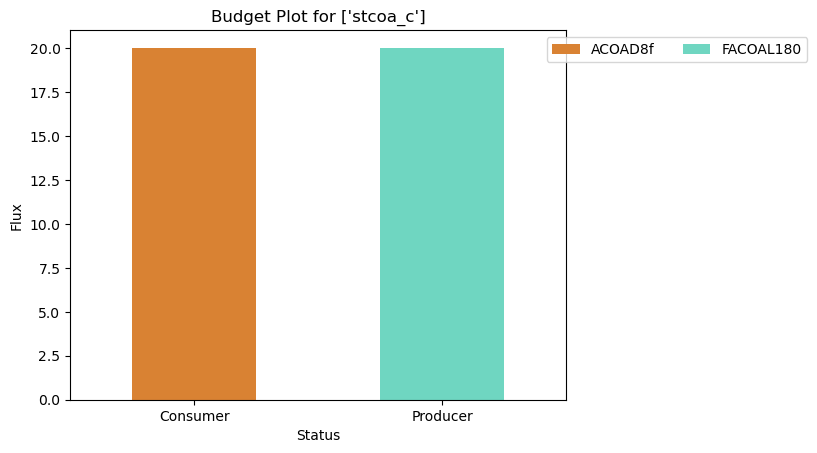

In [264]:
budget_plot = make_budget_plot(all_reactions)
budget_plot